<a href="https://colab.research.google.com/github/mindang/pytorch-master/blob/main/%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98api%EC%82%AC%EC%9A%A9_torch_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!는 한줄씩 실행되도록 !가 없으면 오류 발생
!pip3 install torch
!pip3 install torchvision

In [2]:
import torch
from torchvision import models
import numpy as np
from PIL import Image
from torchvision import transforms
import imageio
import pandas as pd
from matplotlib import pyplot as plt

In [35]:
import torch.nn as nn
import torch.optim as optim

linear_model = nn.Linear(1,1)

In [32]:
#w 와 b는 랜덤 초기화
linear_model.weight , linear_model.bias

(Parameter containing:
 tensor([[-0.3544]], requires_grad=True), Parameter containing:
 tensor([0.4152], requires_grad=True))

In [33]:
x = torch.ones(1).unsqueeze(1)
linear_model(x)

tensor([[0.0607]], grad_fn=<AddmmBackward0>)

#배치를 활용한 Linear Model

In [63]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [64]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([0, 3, 6, 1, 7, 2, 4, 8, 9]), tensor([ 5, 10]))

In [65]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [74]:
#훈련 루프 함수
def training_loop(n_epochs, optimizer , model, loss_fn, x_train, y_train, x_val, y_val):
  for epoch in range(1,n_epochs+1):
    out_train = model(x_train)
    loss_train = loss_fn(out_train, y_train)

    with torch.no_grad():
      out_val = model(x_val)
      loss_val = loss_fn(out_val, y_val)
      assert loss_val.requires_grad==False,"loss_val의 연산그래프가 추적됨"

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    if epoch == 1 or epoch % 1000 == 0:
      print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                    f" Validation loss {loss_val.item():.4f}")

def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [75]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

print("학습 전 파라미터 : ",float(linear_model.weight) , float(linear_model.bias))
training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(),
    #loss_fn = loss_fn,
    x_train = t_un_train,
    y_train = t_c_train, 
    x_val = t_un_val,
    y_val = t_c_val)

print("학습 후 파라미터 : ",end="")
print(float(linear_model.weight),float(linear_model.bias))

학습 전 파라미터 :  -0.1433577537536621 -0.5271774530410767
Epoch 1, Training loss 202.7477, Validation loss 295.8791
Epoch 1000, Training loss 3.7307, Validation loss 3.6399
Epoch 2000, Training loss 3.1655, Validation loss 2.3456
Epoch 3000, Training loss 3.1539, Validation loss 2.1829
학습 후 파라미터 : 5.239745616912842 -16.72836685180664


#신경망을 이용한 선형문제 해결


In [77]:
seq_model = nn.Sequential(
    nn.Linear(1,13),
    nn.Tanh(),
    nn.Linear(13,1)
)
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [78]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [81]:
#이름 붙이기
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [83]:
seq_model.hidden_linear.weight , seq_model.hidden_linear.bias

(Parameter containing:
 tensor([[ 0.3643],
         [-0.8004],
         [-0.7186],
         [-0.1209],
         [-0.5641],
         [-0.9502],
         [-0.0773],
         [ 0.8499]], requires_grad=True), Parameter containing:
 tensor([ 0.2072,  0.9271, -0.0058,  0.5755, -0.5439, -0.0055,  0.0465, -0.0409],
        requires_grad=True))

In [94]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

print("학습 전 파라미터 : ", list(seq_model.parameters()))
training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    #loss_fn = loss_fn,
    x_train = t_un_train,
    y_train = t_c_train, 
    x_val = t_un_val,
    y_val = t_c_val)

print("학습 후 파라미터 : ", list(seq_model.parameters()))

학습 전 파라미터 :  [Parameter containing:
tensor([[ 0.3643],
        [-0.8004],
        [-0.7186],
        [-0.1209],
        [-0.5641],
        [-0.9502],
        [-0.0773],
        [ 0.8499]], requires_grad=True), Parameter containing:
tensor([ 0.2072,  0.9271, -0.0058,  0.5755, -0.5439, -0.0055,  0.0465, -0.0409],
       requires_grad=True), Parameter containing:
tensor([[ 0.0823, -0.0135,  0.1200,  0.1885,  0.2645, -0.3081, -0.2633,  0.2702]],
       requires_grad=True), Parameter containing:
tensor([0.1064], requires_grad=True)]
Epoch 1, Training loss 164.1225, Validation loss 239.1159
Epoch 1000, Training loss 6.8200, Validation loss 3.8877
Epoch 2000, Training loss 4.3771, Validation loss 0.7934
Epoch 3000, Training loss 2.7529, Validation loss 0.1019
Epoch 4000, Training loss 2.4235, Validation loss 0.0393
Epoch 5000, Training loss 2.3637, Validation loss 0.0423
학습 후 파라미터 :  [Parameter containing:
tensor([[ 0.3503],
        [-0.6164],
        [-0.4308],
        [ 0.5438],
        [-0

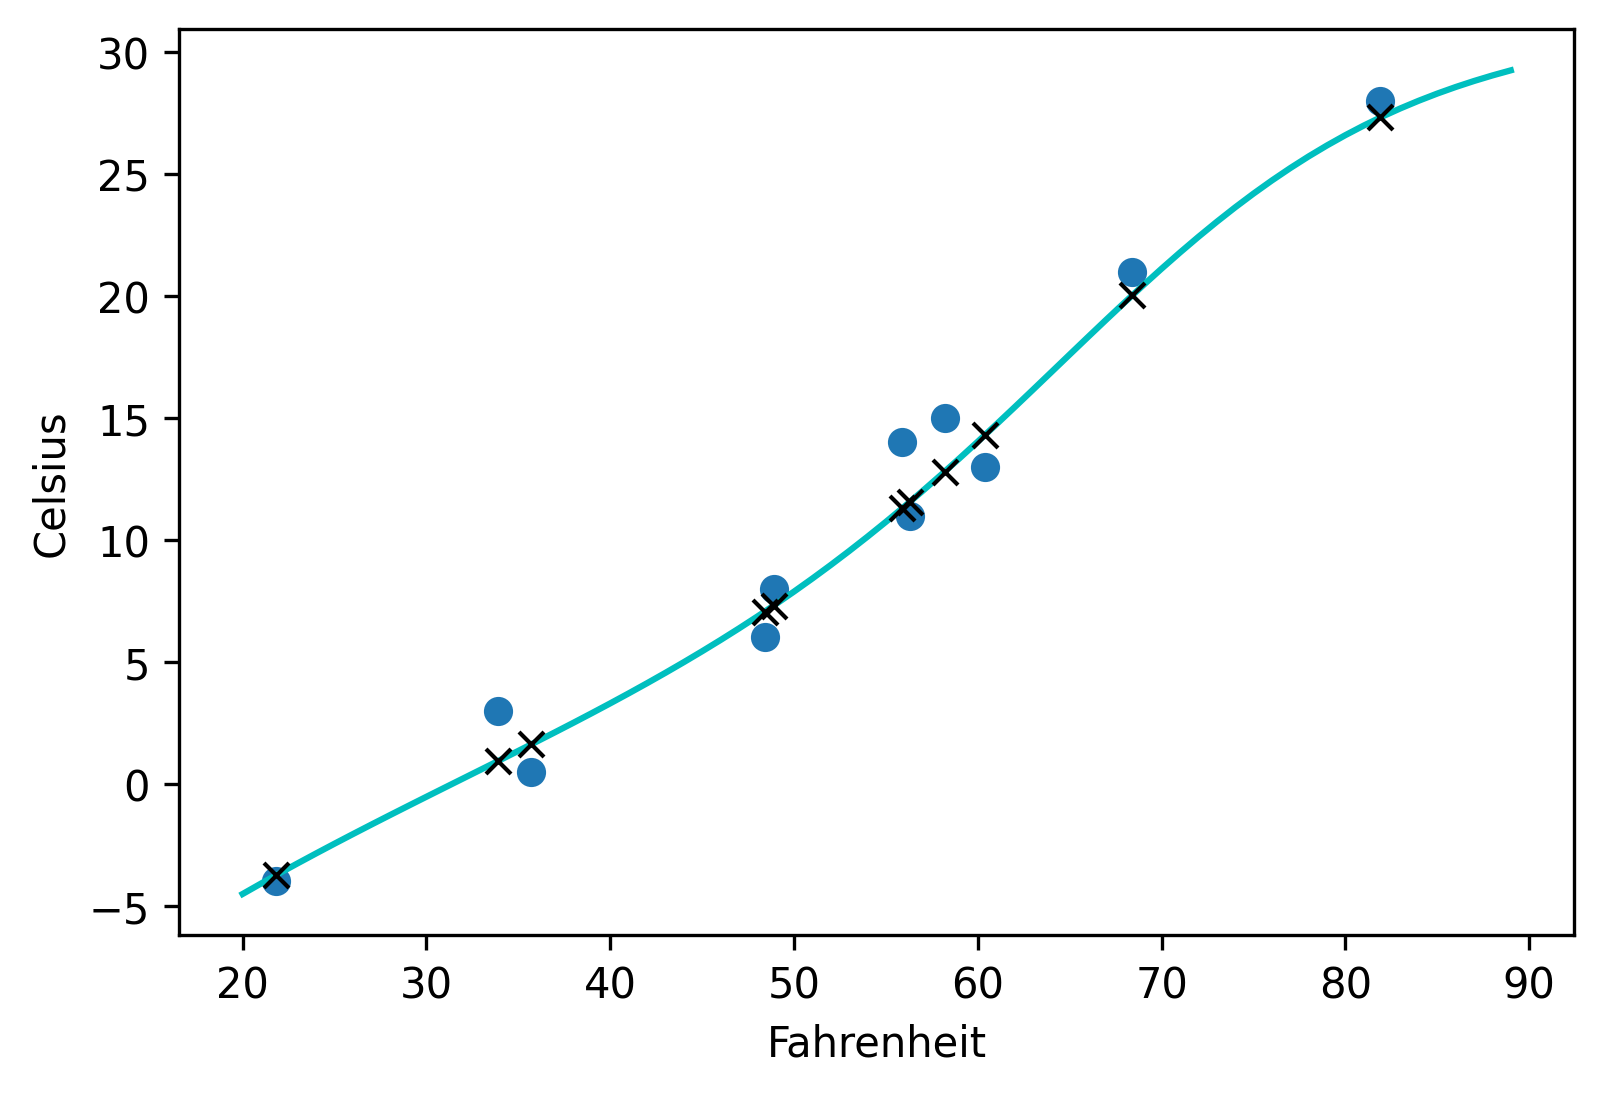

In [96]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=300)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')